In [1]:
import yfinance
import pandas as pd
import numpy as np

# Gerekli veriyi çekiyoruz
df = pd.read_csv("all_companies_balance_statements.csv")
df2 = pd.read_csv("all_companies_cashflow_statements.csv")
df3 = pd.read_csv("all_companies_income_statements.csv")
df4 = pd.read_excel("listof90year.xlsx")

# Prefixler ekleyerek verilerin ne olduğunu ekliyoruz
df_bs = df.add_prefix('bs_')
df_cf = df2.add_prefix('cf_')
df_is = df3.add_prefix('is_')
for dfx in [df, df2, df3]:
    dfx['symbol'] = dfx['symbol'].astype(str).str.strip().str.upper()
    dfx['calendarYear'] = dfx['calendarYear'].astype(str).str.strip()
    dfx['period'] = dfx['period'].astype(str).str.strip().str.upper()

# Join key'leri ekleyip mergelüyoruz
for col in ['symbol', 'calendarYear', 'period']:
    df_bs[col] = df[col]
    df_cf[col] = df2[col]
    df_is[col] = df3[col]
combined_df = df_bs.merge(df_cf, on=['symbol', 'calendarYear', 'period'], how='inner')
combined_df = combined_df.merge(df_is, on=['symbol', 'calendarYear', 'period'], how='inner')

In [ ]:
# Profitability Ratios
# Brüt Kâr Marjı
combined_df['gross_margin'] = combined_df['is_grossProfit'] / combined_df['is_revenue']

# Net Kâr Marjı
combined_df['net_margin'] = combined_df['is_netIncome'] / combined_df['is_revenue']

# Faaliyet Kâr Marjı (Operating Margin)
combined_df['operating_margin'] = combined_df['is_operatingIncome'] / combined_df['is_revenmue']

# ROA - Return on Assets
combined_df['ROA'] = combined_df['is_netIncome'] / combined_df['bs_totalAssets']

# ROE - Return on Equity
combined_df['ROE'] = combined_df['is_netIncome'] / combined_df['bs_totalStockholdersEquity']

# EBITDA Marjı
combined_df['ebitda_margin'] = combined_df['is_ebitda'] / combined_df['is_revenue']

# Liquidity Ratios
# Cari Oran (Current Ratio)
combined_df['current_ratio'] = combined_df['bs_totalCurrentAssets'] / combined_df['bs_totalCurrentLiabilities']

# Asit Test Oranı (Quick Ratio)
combined_df['quick_ratio'] = (
    combined_df['bs_cashAndShortTermInvestments'] + combined_df['bs_netReceivables']
) / combined_df['bs_totalCurrentLiabilities']

# Efficiency Ratios
# Varlık Devir Hızı (Asset Turnover)
combined_df['asset_turnover'] = combined_df['is_revenue'] / combined_df['bs_totalAssets']

# Alacak Devir Hızı
combined_df['receivables_turnover'] = combined_df['is_revenue'] / combined_df['bs_netReceivables']

# Stok Devir Hızı
combined_df['inventory_turnover'] = combined_df['is_costOfRevenue'] / combined_df['bs_inventory']

# Leverage Ratios
# Borç/Özsermaye Oranı (Debt-to-Equity)
combined_df['debt_to_equity'] = combined_df['bs_totalLiabilities'] / combined_df['bs_totalStockholdersEquity']

# Borç/Varlık Oranı (Debt-to-Assets)
combined_df['debt_to_assets'] = combined_df['bs_totalLiabilities'] / combined_df['bs_totalAssets']

# Uzun Vadeli Borç / Özsermaye
combined_df['longterm_debt_to_equity'] = combined_df['bs_longTermDebt'] / combined_df['bs_totalStockholdersEquity']

# Cash Flow Ratios
# Faaliyet Nakit Akışı / Net Gelir
combined_df['operating_cf_to_netincome'] = combined_df['cf_operatingCashFlow'] / combined_df['is_netIncome']

# Serbest Nakit Akışı / Toplam Varlık
combined_df['free_cf_to_assets'] = combined_df['cf_freeCashFlow'] / combined_df['bs_totalAssets']

# Serbest Nakit Akışı / Özsermaye
combined_df['free_cf_to_equity'] = combined_df['cf_freeCashFlow'] / combined_df['bs_totalStockholdersEquity']

ratio_cols = [col for col in combined_df.columns if any(x in col for x in ['margin', 'ratio', 'ROA', 'ROE', 'turnover', 'debt_', 'cf_'])]
for col in ratio_cols:
    combined_df[col] = combined_df[col].replace([np.inf, -np.inf], np.nan)

In [5]:
# Kullanılacak oran sütunları (senin verdiğin oranlara göre seçildi)
ranking_metrics = [
    'gross_margin', 'net_margin', 'operating_margin', 'ROA', 'ROE', 'ebitda_margin',
    'current_ratio', 'quick_ratio',
    'asset_turnover', 'receivables_turnover', 'inventory_turnover',
    'debt_to_equity', 'debt_to_assets', 'longterm_debt_to_equity',
    'operating_cf_to_netincome', 'free_cf_to_assets', 'free_cf_to_equity'
]

ranked_results = []

for idx, row in df4.iterrows():
    year = row['year']
    prev_year = year - 1
    tickers = row[1:].dropna().unique().tolist()

    df_year = combined_df[
        (combined_df['calendarYear'].astype(int) == prev_year) &
        (combined_df['symbol'].isin(tickers))
    ].copy()

    if df_year.empty:
        continue

    # Her metriği sıralayıp 'rank_' önekiyle yeni sütun olarak ekle
    for metric in ranking_metrics:
        if metric in df_year.columns:
            df_year[f"rank_{metric}"] = df_year[metric].rank(ascending=False, method='min')

    # Tüm rank sütunlarını topla
    rank_cols = [col for col in df_year.columns if col.startswith('rank_')]
    df_year['combined_score'] = df_year[rank_cols].sum(axis=1)

    # Toplam skor üzerinden final sıralama
    df_year['final_rank'] = df_year['combined_score'].rank(method='min')
    df_year['ranking_year'] = year

    ranked_results.append(df_year)

# Tüm yıl verilerini birleştir
ranked_df = pd.concat(ranked_results, ignore_index=True)
ranked_df = ranked_df.sort_values(by=['ranking_year', 'final_rank'])

# Sonuç
print("Sıralanmış toplam gözlem:", ranked_df.shape)


Sıralanmış toplam gözlem: (9814, 178)


In [12]:
ranked_df[ranked_df["bs_calendarYear"] == 1999]

,bs_Symbol,bs_Unnamed: 1,bs_date,bs_symbol,bs_reportedCurrency,bs_cik,bs_fillingDate,bs_acceptedDate,bs_calendarYear,bs_period,...,rank_inventory_turnover,rank_debt_to_equity,rank_debt_to_assets,rank_longterm_debt_to_equity,rank_operating_cf_to_netincome,rank_free_cf_to_assets,rank_free_cf_to_equity,combined_score,final_rank,ranking_year
142,EFX,24,1999-12-31,EFX,USD,33185.0,2000-03-30,2000-03-30 00:00:00,1999,FY,...,NaN,32.0,33.0,7.0,148.0,24.0,3.0,1073.0,1.0,2000
212,FLR,25,1999-10-31,FLR,USD,1124198.0,1999-10-31,1999-10-31 00:00:00,1999,FY,...,NaN,107.0,105.0,250.0,12.0,35.0,28.0,1216.0,2.0,2000
137,GIS,25,1999-05-30,GIS,USD,40704.0,1999-08-23,1999-08-23 00:00:00,1999,FY,...,104.0,5.0,7.0,3.0,178.0,42.0,2.0,1289.0,3.0,2000
195,CPB,25,1999-08-01,CPB,USD,16732.0,1999-10-12,1999-10-12 00:00:00,1999,FY,...,133.0,7.0,8.0,4.0,177.0,36.0,1.0,1291.0,4.0,2000
71,MO,25,1999-12-31,MO,USD,764180.0,2000-03-02,2000-03-02 00:00:00,1999,FY,...,170.0,71.0,73.0,82.0,150.0,19.0,9.0,1361.0,5.0,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,VIAV,25,1999-06-30,VIAV,USD,912093.0,1999-09-01,1999-09-01 00:00:00,1999,FY,...,196.0,259.0,261.0,250.0,244.0,176.0,180.0,3040.0,258.0,2000
203,X,25,1999-12-31,X,USD,1163302.0,1999-12-31,1999-12-30 19:00:00,1999,FY,...,81.0,91.0,97.0,147.0,250.0,238.0,233.0,3057.0,259.0,2000
30,AMD,25,1999-12-26,AMD,USD,2488.0,2000-09-22,2000-09-22 00:00:00,1999,FY,...,46.0,183.0,180.0,96.0,252.0,246.0,234.0,3092.0,260.0,2000
100,OKE,24,1999-12-31,OKE,USD,1039684.0,1999-12-31,1999-12-31 00:00:00,1999,FY,...,157.0,122.0,121.0,104.0,243.0,224.0,225.0,3155.0,261.0,2000


In [54]:
ranked_df.groupby('ranking_year').head(5)[['ranking_year', 'symbol', 'final_rank']]


,ranking_year,symbol,final_rank
142,2000,EFX,1.0
212,2000,FLR,2.0
137,2000,GIS,3.0
195,2000,CPB,4.0
71,2000,MO,5.0
...,...,...,...
9492,2025,MA,1.0
9550,2025,COP,2.0
9498,2025,JNJ,3.0
9570,2025,MCO,4.0


[[1909    2]
 [  34   18]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1911
           1       0.90      0.35      0.50        52

    accuracy                           0.98      1963
   macro avg       0.94      0.67      0.75      1963
weighted avg       0.98      0.98      0.98      1963



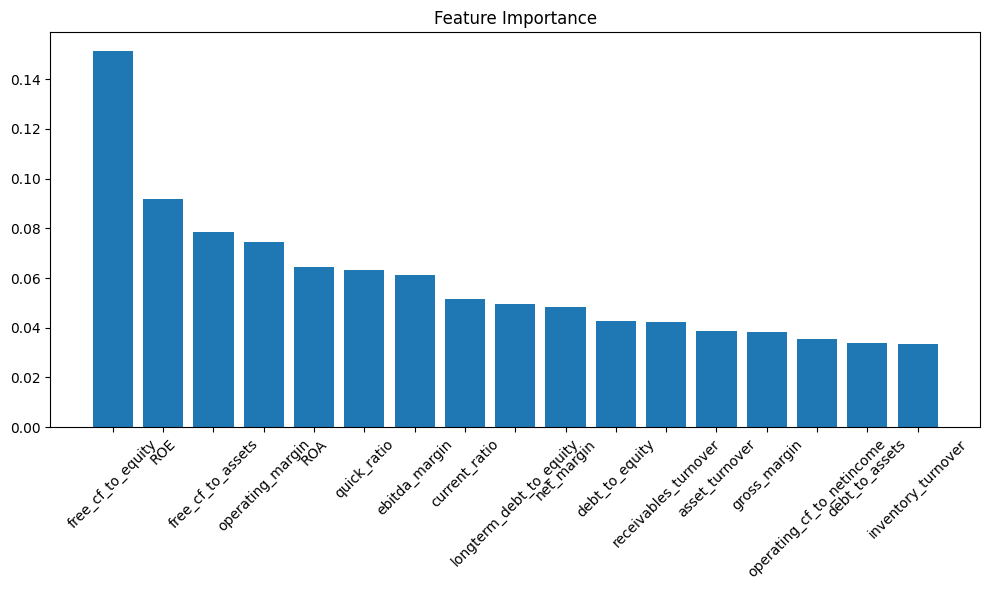

In [55]:
# Yeni hedef sütun
ranked_df['top10'] = (ranked_df['final_rank'] <= 10).astype(int)
# Özellikler (rasyolar)
X = ranked_df[ranking_metrics]

# Hedef değişken (ilk 10'a girme)
y = ranked_df['top10']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Tahmin
y_pred = model.predict(X_test)

# Performans değerlendirmesi
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
import matplotlib.pyplot as plt

importances = model.feature_importances_
feat_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feat_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()


In [57]:
# Özellik önemlerini pandas serisine çevir
importances = pd.Series(model.feature_importances_, index=ranking_metrics)

# Normalize edelim ki toplam 1 olsun (ağırlık toplamı)
weights = importances / importances.sum()
weighted_ranked_results = []

for idx, row in df4.iterrows():
    year = row['year']
    prev_year = year - 1
    tickers = row[1:].dropna().unique().tolist()

    df_year = combined_df[
        (combined_df['calendarYear'].astype(int) == prev_year) &
        (combined_df['symbol'].isin(tickers))
    ].copy()

    if df_year.empty:
        continue

    # Her metriğin sıralamasını hesapla
    for metric in ranking_metrics:
        if metric in df_year.columns:
            df_year[f"rank_{metric}"] = df_year[metric].rank(ascending=False, method='min')

    # Ağırlıklı toplam skoru hesapla
    weighted_score = 0
    for metric in ranking_metrics:
        rank_col = f"rank_{metric}"
        if rank_col in df_year.columns:
            weighted_score += df_year[rank_col] * weights[metric]

    df_year['weighted_score'] = weighted_score

    # Final sıralama
    df_year['final_weighted_rank'] = df_year['weighted_score'].rank(method='min')
    df_year['ranking_year'] = year

    weighted_ranked_results.append(df_year)

# Tüm yılları birleştir
weighted_ranked_df = pd.concat(weighted_ranked_results, ignore_index=True)
weighted_ranked_df = weighted_ranked_df.sort_values(by=['ranking_year', 'final_weighted_rank'])


In [62]:
# İlk 5 firmayı yıl bazlı karşılaştıralım
comparison = weighted_ranked_df.groupby('ranking_year').head(5)[
    ['ranking_year', 'symbol', 'final_weighted_rank']
]
comparison[comparison["ranking_year"]==2000]

,ranking_year,symbol,final_weighted_rank
25,2000,ADBE,1.0
3,2000,LLY,2.0
195,2000,CPB,3.0
71,2000,MO,4.0
137,2000,GIS,5.0


In [67]:
import yfinance as yf
import pandas as pd

def calculate_strategy_returns(ranked_df, rank_column='final_rank', top_n=20):
    portfolio_returns = []

    for year in range(2000, 2024):
        buy_date = f"{year}-04-01"
        sell_date = f"{year+1}-03-30"

        top = ranked_df[ranked_df['ranking_year'] == year].nsmallest(top_n, rank_column)
        tickers = top['symbol'].dropna().unique().tolist()

        if not tickers:
            continue

        try:
            # Verileri çek
            data = yf.download(tickers, start=buy_date, end=sell_date, progress=False)['Adj Close']

            # Tek sembolse Series olarak gelir → DataFrame yap
            if isinstance(data, pd.Series):
                data = data.to_frame()

            data = data.ffill().bfill()

            # En yakın tarihleri belirle
            buy_date_actual = min(data.index, key=lambda d: abs(pd.Timestamp(buy_date) - d))
            sell_date_actual = min(data.index, key=lambda d: abs(pd.Timestamp(sell_date) - d))

            # Fiyatları al
            buy_prices = data.loc[buy_date_actual]
            sell_prices = data.loc[sell_date_actual]

            # Return hesapla
            returns = (sell_prices / buy_prices) - 1
            avg_return = returns.mean()

            portfolio_returns.append({
                'year': year,
                'buy_date': str(buy_date_actual.date()),
                'sell_date': str(sell_date_actual.date()),
                'average_return': avg_return,
                'tickers': tickers
            })

        except Exception as e:
            print(f"{year} için veri alınamadı: {e}")
            continue

    return pd.DataFrame(portfolio_returns)


In [70]:
def download_prices_safe(tickers, start, end):
    collected_data = {}

    for ticker in tickers:
        try:
            df = yf.download(ticker, start=start, end=end, progress=False)['Adj Close']
            if not df.empty:
                collected_data[ticker] = df
        except Exception as e:
            print(f"Failed to get {ticker}: {e}")
            continue

    return pd.DataFrame(collected_data)
def calculate_strategy_returns(ranked_df, rank_column='final_rank', top_n=20):
    portfolio_returns = []

    for year in range(2000, 2024):
        buy_date = f"{year}-04-01"
        sell_date = f"{year+1}-03-30"

        top = ranked_df[ranked_df['ranking_year'] == year].nsmallest(top_n, rank_column)
        tickers = top['symbol'].dropna().unique().tolist()

        if not tickers:
            continue

        try:
            price_data = download_prices_safe(tickers, buy_date, sell_date)

            if price_data.empty:
                print(f"{year} için hiç veri bulunamadı.")
                continue

            price_data = price_data.ffill().bfill()

            buy_date_actual = min(price_data.index, key=lambda d: abs(pd.Timestamp(buy_date) - d))
            sell_date_actual = min(price_data.index, key=lambda d: abs(pd.Timestamp(sell_date) - d))

            buy_prices = price_data.loc[buy_date_actual]
            sell_prices = price_data.loc[sell_date_actual]

            returns = (sell_prices / buy_prices) - 1
            avg_return = returns.mean()

            portfolio_returns.append({
                'year': year,
                'buy_date': str(buy_date_actual.date()),
                'sell_date': str(sell_date_actual.date()),
                'average_return': avg_return,
                'tickers_used': list(price_data.columns)
            })

        except Exception as e:
            print(f"{year} için genel hata: {e}")
            continue

    return pd.DataFrame(portfolio_returns)


In [71]:
# Klasik sıralama ile getiri
classic_results = calculate_strategy_returns(ranked_df, rank_column='final_rank')

# RF ağırlıklı sıralama ile getiri
rf_results = calculate_strategy_returns(weighted_ranked_df, rank_column='final_weighted_rank')



1 Failed download:
['EFX']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
Failed to get ticker 'FLR' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['FLR']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['GIS']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CPB']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['MO']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['ADBE']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['LLY']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['MSFT']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['TROW']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
Failed to get t

2000 için hiç veri bulunamadı.



1 Failed download:
['CPB']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['EFX']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['USB']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
Failed to get ticker 'CAR' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['CAR']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['PNC']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['ADBE']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
Failed to get ticker 'DLX' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['DLX']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
Failed to get ticker 'SLM' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['SLM']: YFTzMi

2001 için hiç veri bulunamadı.


Failed to get ticker 'PLL' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['PLL']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['EFX']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['ZBH']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
Failed to get ticker 'DLX' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['DLX']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['YUM']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['GIS']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
Failed to get ticker 'PCG' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['PCG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
Failed to get ticker 'SLM' re

2002 için hiç veri bulunamadı.



1 Failed download:
['PNC']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['EFX']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['BK']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
Failed to get ticker 'SNV' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['SNV']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['FCX']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['YUM']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['PGR']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CMA']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['ORCL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed downloa

2003 için hiç veri bulunamadı.



1 Failed download:
['CL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
Failed to get ticker 'FHN' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['FHN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['BK']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['EFX']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['PGR']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['FCX']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
Failed to get ticker 'SNV' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['SNV']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
Failed to get ticker 'LPX' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['LPX']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['BAC']: J

2004 için hiç veri bulunamadı.



1 Failed download:
['BK']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
Failed to get ticker 'SNV' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['SNV']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['MCO']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['PGR']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['AXP']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CMA']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['KEY']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['WFC']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['TPR']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download

2005 için hiç veri bulunamadı.



1 Failed download:
['MCO']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['KEY']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['WAT']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['FCX']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
Failed to get ticker 'SNV' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['SNV']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['ADBE']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['FITB']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CMA']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['TPR']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed downl

2006 için hiç veri bulunamadı.



1 Failed download:
['MCO']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['WFC']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['FCX']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['FITB']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['BK']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
Failed to get ticker 'SNV' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['SNV']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['HUM']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['PNC']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['WAT']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed downloa

2007 için hiç veri bulunamadı.



1 Failed download:
['WU']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CLX']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['SPGI']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['AFL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['WAT']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['MTB']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['YUM']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['TROW']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['TPR']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['PGR']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed 

2008 için hiç veri bulunamadı.



1 Failed download:
['MO']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['PM']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['AXP']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['UPS']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['MTB']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['MCHP']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['WAT']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['TPR']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['AZO']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['IBM']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed do

2009 için hiç veri bulunamadı.



1 Failed download:
['WU']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['NFLX']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['VRSN']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['JPM']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['WFC']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['PM']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['HSY']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['FITB']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['AFL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['IBM']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['SPG']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed

2010 için hiç veri bulunamadı.



1 Failed download:
['VRSN']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['WU']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['PM']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['AXP']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['NFLX']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['BKNG']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['AFL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['MTB']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['YUM']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['HSY']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CLX']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed

2011 için hiç veri bulunamadı.


Failed to get ticker 'TRIP' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['TRIP']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['PM']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['AXP']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['UPS']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['GILD']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['BKNG']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['WU']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['WYNN']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CF']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['MCD']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed down

2012 için hiç veri bulunamadı.



1 Failed download:
['MCO']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['ABBV']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['BKNG']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['CL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['AFL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
Failed to get ticker 'TRIP' reason: Expecting value: line 1 column 1 (char 0)

1 Failed download:
['TRIP']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['HSY']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['MO']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['WU']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed download:
['AXP']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')

1 Failed downl

KeyboardInterrupt: 

In [65]:
summary_df = pd.DataFrame({
    'year': classic_results['year'],
    'classic_avg_return': classic_results['average_return'].values,
    'rf_weighted_avg_return': rf_weighted_results['average_return'].values
})

summary_df['difference'] = summary_df['rf_weighted_avg_return'] - summary_df['classic_avg_return']
print(summary_df)

print("\nOrtalama Getiri (Classic):", summary_df['classic_avg_return'].mean())
print("Ortalama Getiri (RF Weighted):", summary_df['rf_weighted_avg_return'].mean())
print("Ortalama Getiri Farkı:", summary_df['difference'].mean())


KeyError: 'year'